## Import libraries

In [267]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder

In [268]:
# Ignore warnings
pd.options.mode.chained_assignment = None #Ignore pandas warning

## Data exploring

In [269]:
url = "https://raw.githubusercontent.com/sinhvienfpt/UsedCarPricePrediction/main/assets/data/train-data.csv"

In [270]:
df = pd.read_csv(url,index_col=0)
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [271]:
print(df.shape)

(6019, 13)


### Data Cleaning

#### Null value

In [272]:
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [273]:
# Drop column New_Price
df = df.drop("New_Price",axis=1)

# Drop all null row
df = df.dropna(how='any')

#### `Year`
Add a column `Age` calculated by subtracting the year when the data collected (2019) from the `year`

In [274]:
df["Age"] = 2019 - df["Year"]

#### `Mileage`
The `Mileage` column in your data uses two different units of measurement: 'km/kg' and 'kmpl'.

In [275]:
kmkg = 0
kmpl = 0
for i in df.Mileage:
    if str(i).endswith("km/kg"):
        kmkg+=1
    elif str(i).endswith("kmpl"):
        kmpl+=1
print('The number of rows with Km/Kg : {} '.format(kmkg))
print('The number of rows with Kmpl : {} '.format(kmpl))

The number of rows with Km/Kg : 66 
The number of rows with Kmpl : 5909 


So we can see the amount of rows with Kmpl is greater than Km/Kg (nearly 90 times). So I decided to convert from Km/Kg into Kmpl. Let take a view at the fuel_type which use km/kg for Mileage.

In [276]:
kmkg_fuel_type = set()
for i in df[df.Mileage.str.endswith("km/kg")].Fuel_Type:
    kmkg_fuel_type.add(i)
print('Fuel type for km/kg : {}'.format(kmkg_fuel_type))

Fuel type for km/kg : {'CNG', 'LPG'}


`CNG` (Compressed Natural Gas) and `LPG` (Liquefied Petroleum Gas) are two types of gas fuels that use km/kg units in the data.

| Characteristic | CNG | LPG |
|----------------|-----|-----|
| Density | 0.75 - 0.83 Kg/Sm³ | 0.51 - 0.56 kg/L |
|Average Desity| 0.79 Kg/Sm³| 0.535 kg/L|

In [277]:
# Convert km/kg to kmpl
for i in range(len(df)):
    m = df.Mileage.iloc[i]
    m = str(m)
    if ' ' in m:
        m,unit = m.split(" ")
        
        if unit == "km/kg":
            if df.Fuel_Type.iloc[i] == "CNG":
                m = float(m)*0.79
            elif df.Fuel_Type.iloc[i] == "LPG":
                m = float(m)*0.535
    
    df["Mileage"].iloc[i] = round(float(m),2)

In [278]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Age
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,21.01,998 CC,58.16 bhp,5.0,1.75,9
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582 CC,126.2 bhp,5.0,12.50,4
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2,1199 CC,88.7 bhp,5.0,4.50,8
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248 CC,88.76 bhp,7.0,6.00,7
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968 CC,140.8 bhp,5.0,17.74,6


#### `Engine` and `Power`

In [279]:
# Find the units of columns Power
tmp = df["Power"].str.split(" ").str[1].unique()
print(tmp)

# Find the units of columns Engine
tmp = df["Engine"].str.split(" ").str[1].unique()
print(tmp)

['bhp']
['CC']


In [280]:
# Convert them  to numeric
def safe_float(x):
    try:
        return float(x.split()[0])
    except:
        return np.nan

df["Power"] = df["Power"].apply(safe_float)
df["Engine"] = df["Engine"].apply(safe_float)

df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Age
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,21.01,998.0,58.16,5.0,1.75,9
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,4
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2,1199.0,88.70,5.0,4.50,8
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,7
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968.0,140.80,5.0,17.74,6


#### Category variables

In [281]:
df["Location"].unique()

array(['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Hyderabad', 'Jaipur',
       'Kochi', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad'],
      dtype=object)

The column `Location` has 10 unique values, that's too much for One Hot encoding

In [282]:
df["Fuel_Type"].unique()

array(['CNG', 'Diesel', 'Petrol', 'LPG'], dtype=object)

In [283]:
df["Fuel_Type"].value_counts()

Diesel    3195
Petrol    2714
CNG         56
LPG         10
Name: Fuel_Type, dtype: int64

In [284]:
# Drop value Electric cuz it has only 2 rows compared with ~6000 rows in the Fuel_Type
df = df[df["Fuel_Type"] != "Electric"]
df["Fuel_Type"].value_counts()

Diesel    3195
Petrol    2714
CNG         56
LPG         10
Name: Fuel_Type, dtype: int64

In [285]:
# One hot
ohe = OneHotEncoder(sparse=False)
ohe.fit(df[["Fuel_Type"]])
ohe.categories_

[array(['CNG', 'Diesel', 'LPG', 'Petrol'], dtype=object)]

In [286]:
ohe.transform(df[["Fuel_Type"]])
df[ohe.categories_[0]] = ohe.transform(df[["Fuel_Type"]])

In [287]:
df["Transmission"].unique()

array(['Manual', 'Automatic'], dtype=object)

In [288]:
# One hot
ohe = OneHotEncoder(sparse=False)
ohe.fit(df[["Transmission"]])
ohe.categories_

[array(['Automatic', 'Manual'], dtype=object)]

In [289]:
ohe.transform(df[["Transmission"]])
df[ohe.categories_[0]] = ohe.transform(df[["Transmission"]])
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Age,CNG,Diesel,LPG,Petrol,Automatic,Manual
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,21.01,998.0,58.16,5.0,1.75,9,1.0,0.0,0.0,0.0,0.0,1.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,4,0.0,1.0,0.0,0.0,0.0,1.0
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2,1199.0,88.70,5.0,4.50,8,0.0,0.0,0.0,1.0,0.0,1.0
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,7,0.0,1.0,0.0,0.0,0.0,1.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968.0,140.80,5.0,17.74,6,0.0,1.0,0.0,0.0,1.0,0.0


In [290]:
df["Owner_Type"].unique()

array(['First', 'Second', 'Fourth & Above', 'Third'], dtype=object)

In [291]:
# Ondinary decoding
df["Owner_Type"] = df["Owner_Type"].map({"First":1,"Second":2,"Third":3,"Fourth & Above":4})
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Age,CNG,Diesel,LPG,Petrol,Automatic,Manual
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,1,21.01,998.0,58.16,5.0,1.75,9,1.0,0.0,0.0,0.0,0.0,1.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,1,19.67,1582.0,126.20,5.0,12.50,4,0.0,1.0,0.0,0.0,0.0,1.0
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,1,18.2,1199.0,88.70,5.0,4.50,8,0.0,0.0,0.0,1.0,0.0,1.0
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,1,20.77,1248.0,88.76,7.0,6.00,7,0.0,1.0,0.0,0.0,0.0,1.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2,15.2,1968.0,140.80,5.0,17.74,6,0.0,1.0,0.0,0.0,1.0,0.0


**Drop no-need columns**

In [292]:
cols_to_drop = ["Year","Fuel_Type","Transmission"]
df = df.drop(cols_to_drop,axis=1)
df.head()

,Name,Location,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,Age,CNG,Diesel,LPG,Petrol,Automatic,Manual
0,Maruti Wagon R LXI CNG,Mumbai,72000,1,21.01,998.0,58.16,5.0,1.75,9,1.0,0.0,0.0,0.0,0.0,1.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,41000,1,19.67,1582.0,126.20,5.0,12.50,4,0.0,1.0,0.0,0.0,0.0,1.0
2,Honda Jazz V,Chennai,46000,1,18.2,1199.0,88.70,5.0,4.50,8,0.0,0.0,0.0,1.0,0.0,1.0
3,Maruti Ertiga VDI,Chennai,87000,1,20.77,1248.0,88.76,7.0,6.00,7,0.0,1.0,0.0,0.0,0.0,1.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,40670,2,15.2,1968.0,140.80,5.0,17.74,6,0.0,1.0,0.0,0.0,1.0,0.0


Save it to new csv file

In [293]:
df.to_csv('../assets/data/cleaned.csv',index=False)

### Visualization

In [294]:
df.head()

,Name,Location,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,Age,CNG,Diesel,LPG,Petrol,Automatic,Manual
0,Maruti Wagon R LXI CNG,Mumbai,72000,1,21.01,998.0,58.16,5.0,1.75,9,1.0,0.0,0.0,0.0,0.0,1.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,41000,1,19.67,1582.0,126.20,5.0,12.50,4,0.0,1.0,0.0,0.0,0.0,1.0
2,Honda Jazz V,Chennai,46000,1,18.2,1199.0,88.70,5.0,4.50,8,0.0,0.0,0.0,1.0,0.0,1.0
3,Maruti Ertiga VDI,Chennai,87000,1,20.77,1248.0,88.76,7.0,6.00,7,0.0,1.0,0.0,0.0,0.0,1.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,40670,2,15.2,1968.0,140.80,5.0,17.74,6,0.0,1.0,0.0,0.0,1.0,0.0


In [300]:
fuel_type_cols = ['CNG', 'Diesel', 'LPG', 'Petrol']
transmission_cols = ['Automatic', 'Manual']
_numerical_cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Age']

#### Bar chart

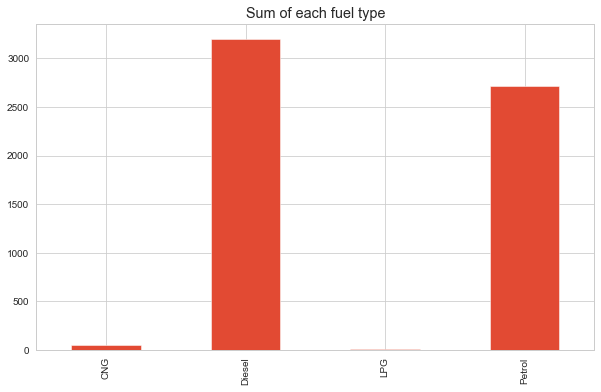

In [296]:
# Bar chart for sum of each fuel_type_cols 
plt.figure(figsize=(10,6))
df[fuel_type_cols].sum().plot(kind='bar')
plt.title('Sum of each fuel type')
plt.show()

As we can see, cars running on `Diesel` or `Petrol` fuel are **significantly larger** in number than cars running on `CNG` or `LPG`. So in the model, the accuracy will be higher in these types.

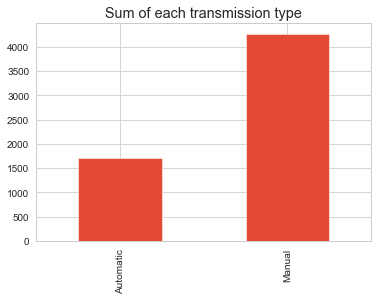

In [297]:
# Bar chart for sum of each transmission_cols
plt.figure()
df[transmission_cols].sum().plot(kind='bar')
plt.title('Sum of each transmission type')
plt.show()

The majority of cars in the data are `Manual` cars, meaning the data was collected a long time ago. The predicted price was only correct at that time **(5 years ago)**.

 If we want to predict current prices, adjusting for inflation is necessary.

#### Box plot

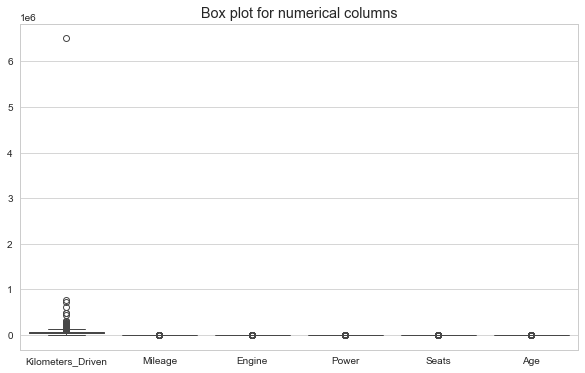

In [301]:
# Box plot for numerical columns
plt.figure(figsize=(10,6))
sns.boxplot(data=df[_numerical_cols])
plt.title('Box plot for numerical columns')
plt.show()


There're ouliner in `Kilometers_Driven` colums. Remove it

In [302]:
# Remove outliers in Kilometers_Driven
IQR = df['Kilometers_Driven'].quantile(0.75) - df['Kilometers_Driven'].quantile(0.25)
lower_bound = df['Kilometers_Driven'].quantile(0.25) - 1.5*IQR
upper_bound = df['Kilometers_Driven'].quantile(0.75) + 1.5*IQR
df = df[(df['Kilometers_Driven'] > lower_bound) & (df['Kilometers_Driven'] < upper_bound)]

In [303]:
df.shape

(5774, 16)

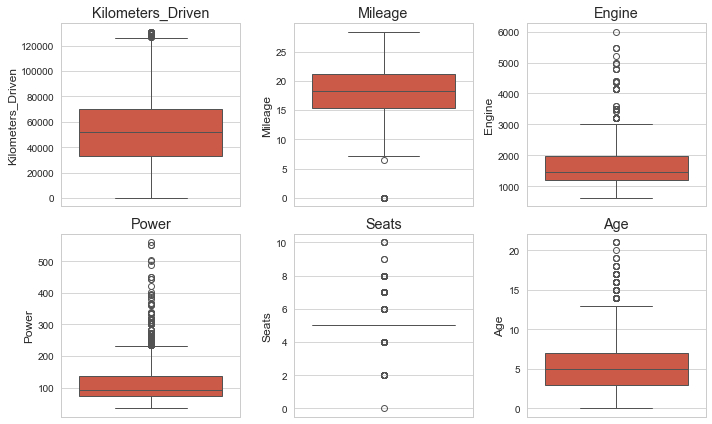

In [306]:
# Box plot for each numerical columns
plt.figure(figsize=(10,6))
for i,col in enumerate(_numerical_cols):
    plt.subplot(2,3,i+1)
    sns.boxplot(data=df[col])
    plt.title(col)
plt.tight_layout()

plt.show()


#### Correlation heatmap

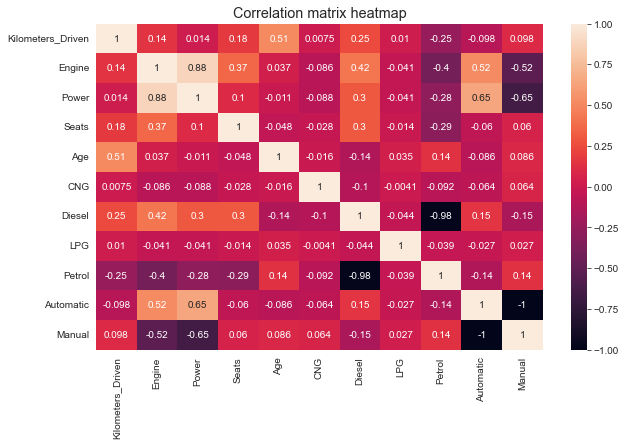

In [310]:
# Correlation matrix heatmap
numerical_cols = _numerical_cols + fuel_type_cols + transmission_cols
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols].corr(),annot=True)
plt.title('Correlation matrix heatmap')
plt.show()
